<a href="https://colab.research.google.com/github/karthik-25/music-generator/blob/main/music_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generation with Deep Learning

## Project Overview
This project explores the fascinating intersection of artificial intelligence and music by employing deep learning techniques to generate musical sequences. Utilizing Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN) optimized for learning long-term dependencies, the goal was to model and generate musical notes based on a corpus of music. For this project, a collection of piano MIDI files were used from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro).

This project follows the foundational steps laid out in the TensorFlow tutorial: [Generate music with an RNN](https://www.tensorflow.org/tutorials/audio/music_generation#setup). It also incorporates additional explorations and customizations to enhance the model's performance and creativity in music generation.

## Objectives



* **Model Training:** Train an LSTM model to capture patterns in musical sequences.
* **Music Generation:** Use the model to create new sequences with controlled randomness.
* **Evaluation and Experimentation:** Assess performance and tweak hyperparameters to refine the output.

## Technologies
* **TensorFlow & Keras:** For model architecture and training.
* **NumPy & Pandas:** For data manipulation and structuring.
* **Matplotlib:** For visualizing training progress.

## Project Structure
1. **Data Preparation:** Normalize and sequence musical data for LSTM training.
2. **Model Building:** Construct an LSTM model suited for sequence learning.
3. **Training and Evaluation:** Implement training with early stopping and checkpointing, followed by model evaluation.
4. **Music Generation:** Generate music with temperature-adjusted predictions.
5. **Conclusion and Future Work:** Overview of outcomes and potential enhancements.

### Install Dependencies, Import Packages & Set Initial Parameters

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1. Data Preparation

### Download data

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 0s 0us/step


In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### Inspect Midi File

In [15]:
# load sample midi file
sample_file = filenames[123]
pm = pretty_midi.PrettyMIDI(sample_file)

# view instrument details
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name, '\n')

# view notes of sample pretty_midi object
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')
print()

# listen to sample
def display_audio(pm, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # create shorter version of generated waveform
  waveform_short = waveform[:seconds * _SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

Number of instruments: 1
Instrument name: Acoustic Grand Piano 

0: pitch=47, note_name=B2, duration=1.2982
1: pitch=50, note_name=D3, duration=1.3411
2: pitch=54, note_name=F#3, duration=1.3672
3: pitch=59, note_name=B3, duration=2.3190
4: pitch=66, note_name=F#4, duration=0.1081
5: pitch=67, note_name=G4, duration=0.1094
6: pitch=64, note_name=E4, duration=0.1289
7: pitch=66, note_name=F#4, duration=0.0781
8: pitch=64, note_name=E4, duration=0.0911
9: pitch=62, note_name=D4, duration=2.1042



### Generate notes from MIDI file

In [16]:
# given a midi file, return a pandas dataframe with all notes sorted in order of
# their start times in the midi file. Dataframe contains pitch of the note,
# the start and end times, the step (offset from previous note), and duration
# of the note

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     47  1.006510  2.304688  0.000000  1.298177
1     50  1.071615  2.412760  0.065104  1.341146
2     54  1.125000  2.492188  0.053385  1.367188
3     59  1.210938  3.529948  0.085938  2.319010
4     66  3.718750  3.826823  2.507812  0.108073

In [17]:
# to view actual note names (instead of integers)
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B2', 'D3', 'F#3', 'B3', 'F#4', 'G4', 'E4', 'D4', 'B3', 'F#4'],
      dtype='<U3')

### Visualizations

In [18]:
# visualise the notes from the dataframe. since they are sorted, pianoroll
# represents the midi file
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

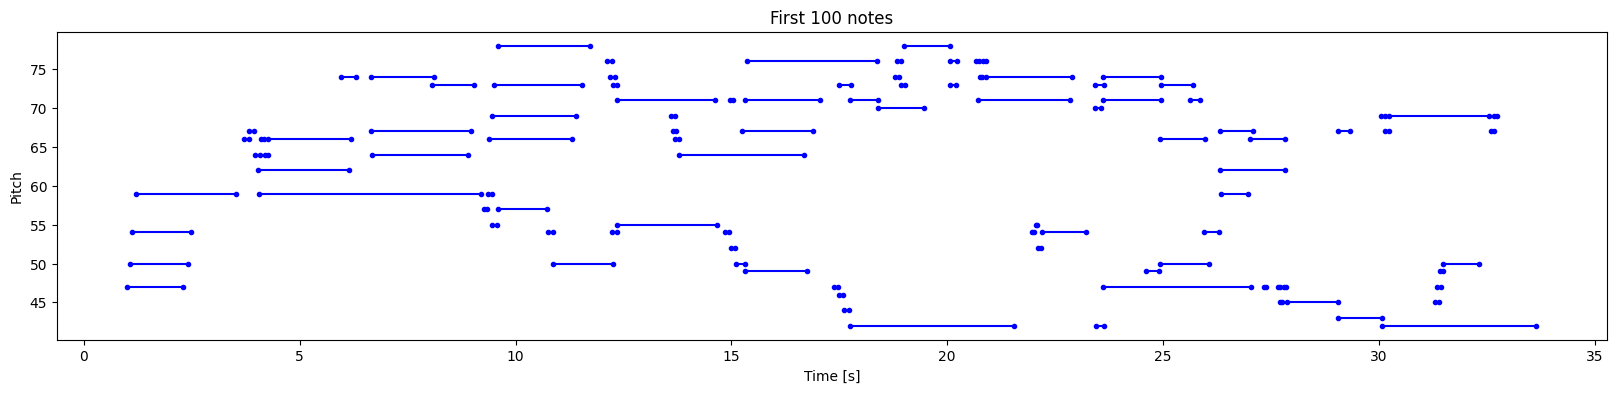

In [19]:
plot_piano_roll(raw_notes, count=100)

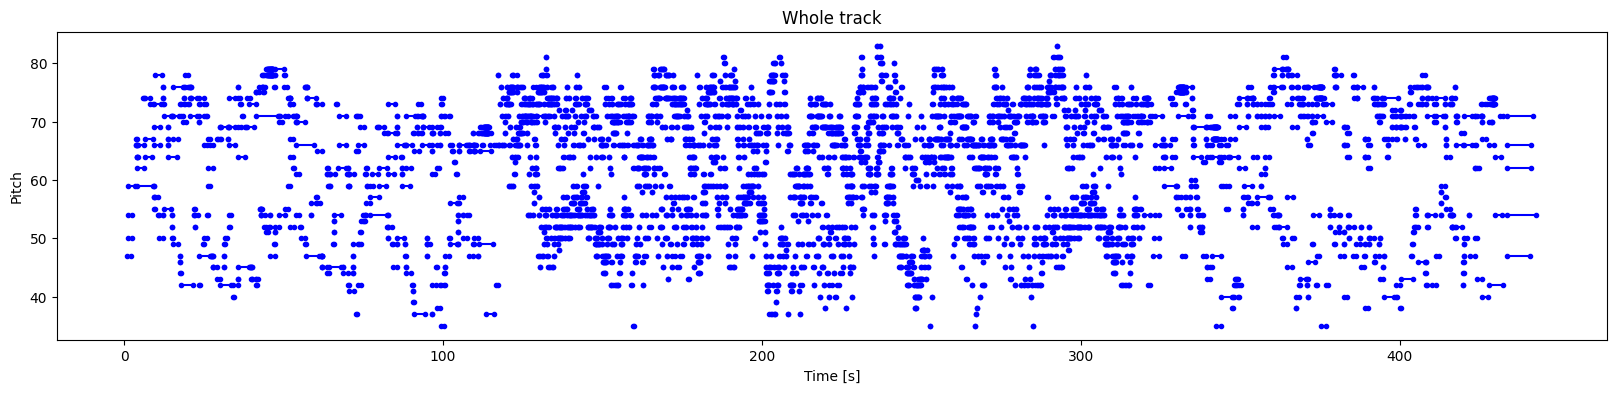

In [20]:
plot_piano_roll(raw_notes)

In [25]:
# visualise distributions of the pitch, step and duration
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

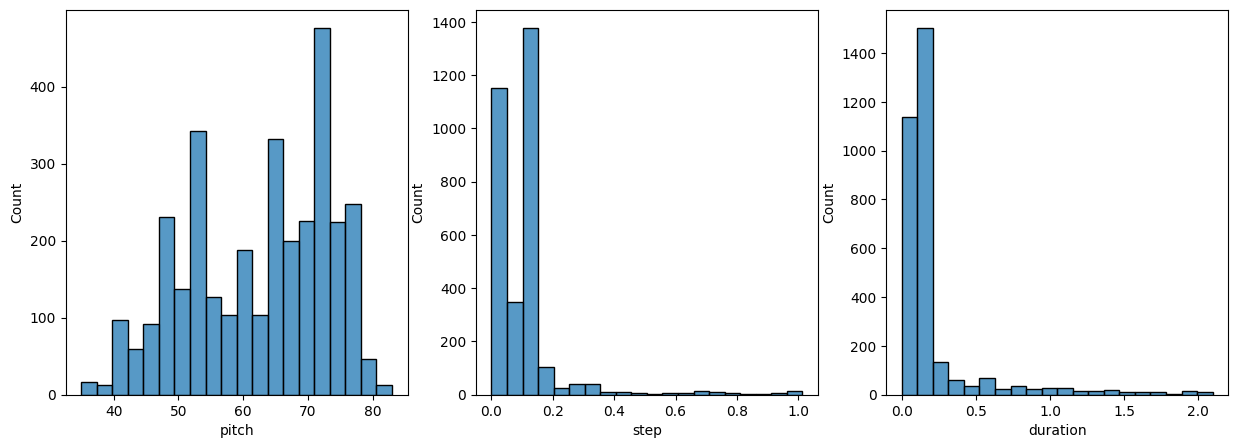

In [26]:
plot_distributions(raw_notes)

### Generate MIDI file from notes

In [28]:
# given dataframe of notes, generate a midi file
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [32]:
# testing generation
sample_file_regen = 'sample_file_regen.midi'
sample_file_regen_pm = notes_to_midi(
    raw_notes, out_file=sample_file_regen, instrument_name=instrument_name)

display_audio(sample_file_regen_pm)

### Create Training Set

In [33]:
num_files = 1200
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

print('Number of notes parsed:', len(all_notes))

Number of notes parsed: 6638947


In [27]:
# transform training data into: No. of notes rows x 3 columns
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# convert training data into tensor dataset
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

In [29]:
# with the above dataset of all notes from all files in order, split them up
# into sequences of specified length to be used to train the model.
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128,) -> tf.data.Dataset:

  # Take 1 extra for the labels
  seq_length = seq_length + 1

  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch to value between 0 and 1
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels from sequences
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

In [31]:
# view sequences generated
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape, '\n')
  print('sequence elements (first 10):', seq[0: 10], '\n')
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.4609375  0.         0.60625   ]
 [0.3671875  0.03645833 0.65208333]
 [0.4765625  0.509375   0.50625   ]
 [0.3828125  0.03229167 0.45416667]
 [0.4375     0.39895833 0.47708333]
 [0.34375    0.003125   0.47916667]
 [0.4765625  0.48854167 0.28125   ]
 [0.3828125  0.01458333 0.553125  ]
 [0.4609375  0.703125   1.69375   ]
 [0.4453125  0.03229167 1.17604167]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.02916666666666501>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.28125>}


In [32]:
# split train set into batches of 64
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

# 2. Model Building

In [34]:
# defining mean squared error with positive pressure (we want model to avoid negative
# predictions). this error function will be used to train for step and duration.
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [35]:
# building LSTM model

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

# model will have 3 outputs
outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

# loss functions
loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 3)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [36]:
# when evaluating the model, it was seen that pitch loss dominates the overall
# loss. loss weights were added to balance the losses and train the model better
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

# to evaluate the model
# model.evaluate(train_ds, return_dict=True)

In [37]:
# add checkpoints and early stopping to callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

# 3.Training and Evaluation

In [38]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
6636/6636 [==============================] - 150s 8ms/step - loss: 0.3033 - duration_loss: 0.0802 - pitch_loss: 3.9409 - step_loss: 0.0260
Epoch 2/50
6636/6636 [==============================] - 51s 8ms/step - loss: 0.2908 - duration_loss: 0.0765 - pitch_loss: 3.8060 - step_loss: 0.0240
Epoch 3/50
6636/6636 [==============================] - 50s 8ms/step - loss: 0.2832 - duration_loss: 0.0745 - pitch_loss: 3.7125 - step_loss: 0.0230
Epoch 4/50
6636/6636 [==============================] - 51s 8ms/step - loss: 0.2784 - duration_loss: 0.0732 - pitch_loss: 3.6574 - step_loss: 0.0224
Epoch 5/50
6636/6636 [==============================] - 51s 8ms/step - loss: 0.2752 - duration_loss: 0.0717 - pitch_loss: 3.6291 - step_loss: 0.0220
Epoch 6/50
6636/6636 [==============================] - 54s 8ms/step - loss: 0.2725 - duration_loss: 0.0703 - pitch_loss: 3.6119 - step_loss: 0.0216
Epoch 7/50
6636/6636 [==============================] - 51s 8ms/step - loss: 0.2706 - duration_loss: 0.06

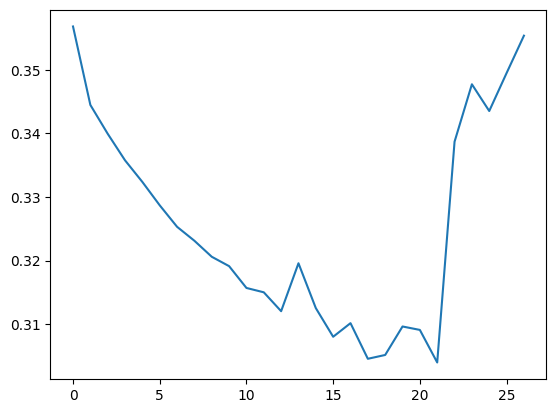

In [117]:
# visualise loss across epochs
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 4. Music Generation

In [118]:
# function to predict the next note given input notes and temperature for
# creative randomness. note generated is a tuple of (pitch, step, duration)
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 500

# the initial sequence of notes
# pitch is normalized similar to training sequences
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

# generate notes using the model
# each iteration generates 1 note. the input sequence shifts to include the new
# note and exclude the first note. this updated sequence is used as input to
# generate the next note.
generated_notes = []
prev_start = 0
for i in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  generated_notes.append((pitch, step, duration, start, end))
  pitch = pitch / vocab_size
  input_note = (pitch, step, duration)
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [120]:
# view sample of generated notes
generated_notes.head(10)

pitch      step  duration     start       end
0     47  0.195014  0.629173  0.195014  0.824187
1     72  0.194803  0.627027  0.389817  1.016844
2     58  0.149603  0.484891  0.539420  1.024311
3     47  0.190646  0.473556  0.730066  1.203622
4     60  0.271509  0.563789  1.001575  1.565363
5     76  0.253503  0.623167  1.255078  1.878245
6     50  0.179605  0.566787  1.434683  2.001470
7     74  0.155391  0.534054  1.590074  2.124128
8     84  0.166999  0.454507  1.757073  2.211581
9     52  0.196600  0.457007  1.953673  2.410680

In [121]:
# listen to generated audio
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

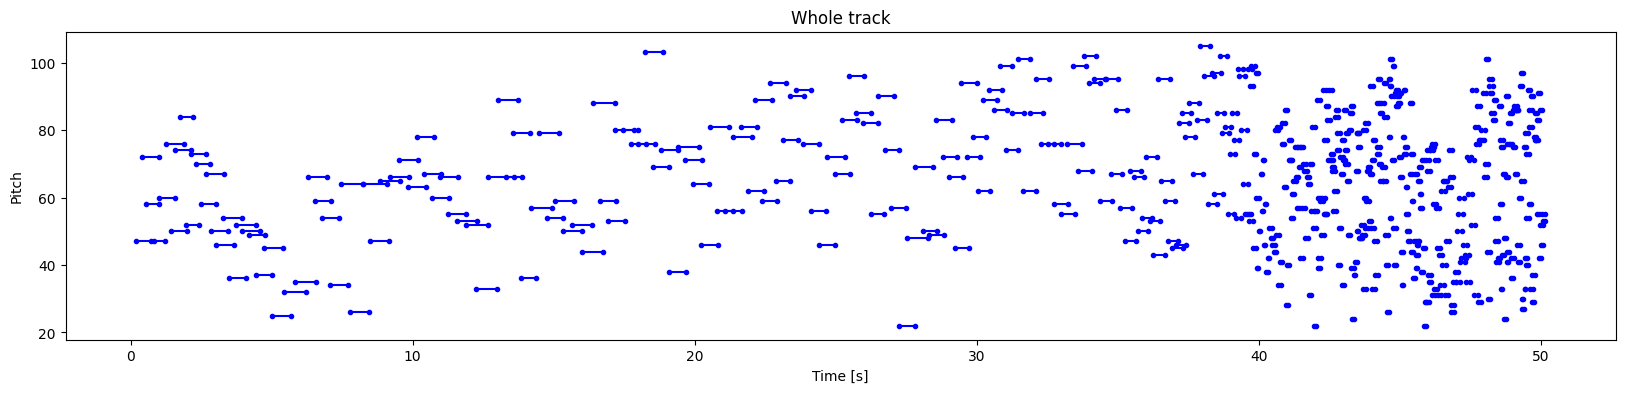

In [122]:
# visualize the generated music
plot_piano_roll(generated_notes)

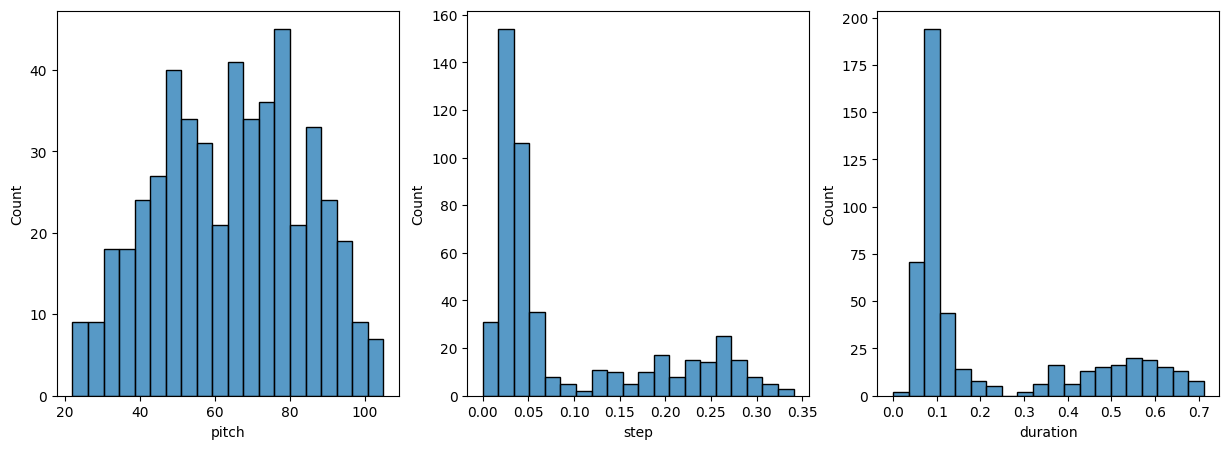

In [123]:
plot_distributions(generated_notes)

# 5. Conclusion and Future Work

This project successfully demonstrates the capability of LSTM networks to learn and generate musical sequences, highlighting the intersection of deep learning and creative arts. By training on a dataset of musical notes, the model learned the underlying patterns and structures, enabling the generation of new music that maintains coherence and reflects the training data's stylistic nuances. The exploration of temperature as a mechanism to control creativity and randomness in the generated sequences further showcased the flexibility and potential of machine learning in artistic creation.

## Potential Enhancements
**Exploring Diverse Datasets:** Training the model on a wider variety of music genres or datasets could enable the generation of music that spans multiple styles or uniquely blends them.

**Improving Model Complexity:** Experimenting with more complex or deeper LSTM architectures, possibly integrating attention mechanisms, could enhance the model's ability to capture more nuanced musical patterns and long-term dependencies.

**Interactive Music Generation:** Developing an interface that allows users to interactively influence the music generation process (e.g., by setting moods, themes, or manually adjusting the temperature) could make the tool more versatile and engaging.

**Exploring Generative Adversarial Networks (GANs):** GANs can potentially generate highly innovative and complex musical compositions